## EE 372 Assignment 2

#### Name:  
#### Date: 

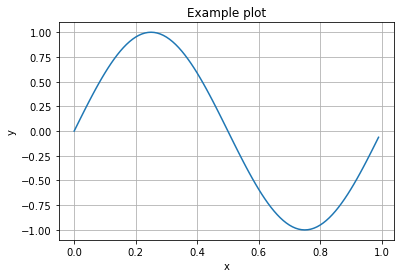

In [1]:
%matplotlib inline

# The only libraries you should need for this assignment. 
# Execute this cell first. (You should get a sine wave.)
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,1.0, 0.01)
y = np.sin(2*np.pi*x)
plt.plot(x,y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Example plot')

### Question I: Validity of Lander-Waterman Statistics

1.

You can view the first 15 lines of the file using the command `samtools view ecoli_aligned_reads.bam | head -15`. Refer to the documentation for the \*.sam file format [here](https://samtools.github.io/hts-specs/SAMv1.pdf). Convert the \*.bam file to a \*.sam file using the `samtools view` command. What position does the first read align to?

The first read aligns to position 1850828.

2.

The length of the _E. coli_ genome is 4639675. Write a function to compute the proportion of the genome by covered by the reads in a given \*.sam file. What proportion of the genome is covered by the reads in ecoli_aligned_reads.bam?

In [2]:
def compute_proportion_covered(filename):
    covered = np.zeros(4639675)
    read_length = 150
    with open(filename) as f:
        for line in f:
            if line[0] != '@':
                pos = int(line.split()[3])-1
                covered[pos:pos+read_length] = 1
    return np.sum(covered)/float(len(covered))
                
p_covered = compute_proportion_covered('ecoli_aligned_reads.sam')
print('%.2f%% of the genome is covered.'%(100*p_covered))

99.47% of the genome is covered.


3.

Subsample the \*.sam file using the ```samtools view``` -s command. You should generate a new \*.sam file for each subsampling. Using the function you wrote above, plot the proportion of the genome covered as a function of $p$, the proportion of reads kept. Interpret what you see (1-2 sentences).

We see that as the proportion of reads kept decreases, so does the proportion of the genome covered. This relationship is not linear, however, as throwing away half the reads results in only a minor decrease in coverage. The rate of genome coverage gain per read decreases as the number of reads increases.

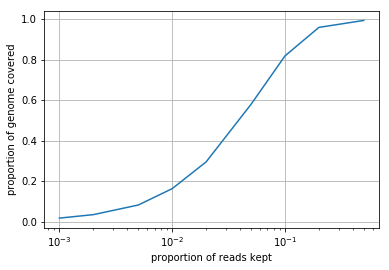

In [14]:
import os

p_reads = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
p_covered = np.zeros(len(p_reads))

for i, p in enumerate(p_reads):
    samp_filename = 'ecoli_aligned_reads_p%s.sam'%(p)
    
    # subsample the sam file
    cmd = 'samtools view -s %s ecoli_aligned_reads.sam > %s'%(p, samp_filename)
    os.system(cmd)
    
    p_covered[i] = compute_proportion_covered(samp_filename)

plt.plot(p_reads, p_covered)b
plt.xscale('log')
plt.xlabel('proportion of reads kept')
plt.ylabel('proportion of genome covered')
plt.grid()

4.

Compute the triple repeat and interleaved statistics of the E. coli genome (available [here](http://portal.nersc.gov/dna/microbial/assembly/uploads/dtse/Mock-Community/E.coli_K12_ATCC_700926.fasta)). Report the number of triple and interleaved repeats of length more than 200. Consider only the forward strand of the reference. _Hint_: Use the software [MUMmer](http://mummer.sourceforge.net/manual/). The `repeat-match` command might be helpful.

We first run the command  `repeat-match -f -n 200 E.coli_K12_ATCC_700926.fasta > ecoli_repeats.txt` to get the positions of all repeats in the genome. Each line in the repeat file contains a repeat (e.g. the start position of the 1st copy of the repeat, and the start position of the 2nd copy of the repeat, and the length of each copy).

We then post process the repeat file. The post processing compares all possible pairs of repeats. It tries to find three patterns:
1. interleaved repeat: r1=...x...x..., r2=...y...y..., and r1 plus r2 has ...x...y...x...y...
2. triple repeat: r1=...x...x..., r2=...x...x..., and r1 plus r2 has ...x...x...x... 
3. interleaved-triple hybrid: r1=...zx...zx..., r2=...yz...yz..., r1 plus r2 has ...zx...yzx...yz...

In [96]:
def find_int_trip_repeat(repeat_list):
    trip_repeats = {}
    trip_repeat_S = []
    l_trip = -1
    
    int_repeats = {}
    int_repeat_S = []
    l_int = -1
    
    int_cnt = 0
    trip_cnt = 0
    overlap_cnt = 0
    for i1 in range(len(repeat_list)):
        for i2 in np.arange(i1+1, len(repeat_list)):
            
            repeat1 = repeat_list[i1]
            p1_1, p1_2, L1 = repeat1
            p1_1e = p1_1+L1-1
            p1_2e = p1_2+L1-1
            
            repeat2 = repeat_list[i2]
            p2_1, p2_2, L2 = repeat2
            p2_1e = p2_1+L2-1
            
            # pattern 1: ...x...x.....
            #            .....y...y...
            if p1_1e<p2_1 and p2_1e<p1_2 and p1_2e<p2_2:
                l_int_new = min(L1,L2)
                r = int_repeats.setdefault(l_int_new, [])
                r.append([repeat1, repeat2])
                int_cnt += 1
                if l_int_new>l_int:
                    l_int = l_int_new
                    int_repeat_S = [repeat1, repeat2]
                    
            # pattern 2: ...x...x.......
            #            .......x...x...
            if L1==L2 and p1_2==p2_1:
                r = trip_repeats.setdefault(L1,[])
                r.append([repeat1, repeat2])
                trip_cnt += 1
                if L1>l_trip:
                    l_trip = L1
                    trip_repeat_S = [repeat1, repeat2]
            
            # pattern 3: ...zxAyzxByz...
            #            ...zx..zx......
            #            ......yz..yz...
            if p1_1e<p2_1 and p2_1<p1_2 and p2_1e>p1_2 and p2_1e<p1_2e and p1_2e<p2_2:
                overlap_cnt += 1
                L_z = p2_1e-p1_2+1
                L_x = L1-L_z
                L_y = L2-L_z
                
                #...z...z...z
                repeat_z_1 = [p1_1, p1_2, L_z]
                repeat_z_2 = [p1_2, p2_2+L_y, L_z]
                r = trip_repeats.setdefault(L_z,[])
                r.append([repeat_z_1, repeat_z_2])
                trip_cnt += 1
                if L_z>l_trip: 
                    l_trip = L_z
                    trip_repeat_S = [repeat_z_1, repeat_z_2]
                    
                #...x.y.x.y...
                repeat_xy_1 = [p1_1+L_z, p1_2+L_z, L_x]
                repeat_xy_2 = [p2_1, p2_2, L_y]
                L_xy = min(L_x, L_y)
                r = int_repeats.setdefault(L_xy, [])
                r.append([repeat_xy_1, repeat_xy_2])
                int_cnt += 1
                if L_xy>l_int: 
                    l_int = L_xy
                    int_repeat_S = [repeat_xy_1, repeat_xy_2]
    
    print('Max-length interleaved repeats:')
    print('    repeats at pos %s and %s (length %s)\n'%int_repeat_S[0] + \
          '    repeats at pos %s and %s (length %s)'%int_repeat_S[1])
    print('Max-length triple repeat:')
    print('    repeats at pos %s, %s, and %s (length %s)' \
          %(trip_repeat_S[0][0], trip_repeat_S[0][1], trip_repeat_S[1][1], l_trip))
    print('Total interleaved repeats = %s (%s from hybrids)'%(int_cnt, overlap_cnt))
    print('Total triple repeats = %s (%s from hybrids)'%(trip_cnt, overlap_cnt))

In [97]:
# extract list of repeats
repeat_list = []    
with open('ecoli_repeats.txt') as rf:
    for i, line in enumerate(rf):
        if i > 1:
            r_copy1_pos, r_copy2_pos, r_len = [int(j) for j in line.split()]
            # only keep repeats that don't overlap
            if r_copy1_pos+r_len-1 < r_copy2_pos: 
                repeat_list.append((min(r_copy1_pos, r_copy2_pos),
                                    max(r_copy1_pos, r_copy2_pos), r_len))
find_int_trip_repeat(sorted(repeat_list))

Max-length interleaved repeats:
    repeats at pos 4164672 and 4206160 (length 1566)
    repeats at pos 4166642 and 4208044 (length 2815)
Max-length triple repeat:
    repeats at pos 15387, 607230, and 2512295 (length 1345)
Total interleaved repeats = 2748 (10 from hybrids)
Total triple repeats = 73 (10 from hybrids)


### Question II: de Bruijn graph assembly

1.

Give the 5-mer spectrum of TAAAAACCCCAAAAAG. How many different assemblies are consistent with the 5-mer spectrum?

Because of the ambiguity associated with the two AAAAA k-mers, there are three possible assemblies:

- TAAAAACCCCAAAAAG
- TAAAAAACCCCAAAAG
- TAAAACCCCAAAAAAG

In [2]:
from collections import Counter
st = 'TAAAAACCCCAAAAAG'
list_of_reads = [st[i:i+5] for i in range(len(st)-4)]
kspec = Counter(list_of_reads)

for kmer in kspec:
    print('%s appears %s time(s).'%(kmer, kspec[kmer]))

AACCC appears 1 time(s).
AAACC appears 1 time(s).
CCCAA appears 1 time(s).
TAAAA appears 1 time(s).
CCAAA appears 1 time(s).
ACCCC appears 1 time(s).
CCCCA appears 1 time(s).
AAAAA appears 2 time(s).
AAAAC appears 1 time(s).
CAAAA appears 1 time(s).
AAAAG appears 1 time(s).


2.

The support of a k-mer spectrum is the k-mer spectrum with the value of all non-zero k-mers set to 1. Give the assembly of TAAAAACCCCAAAAAG from the support of its 5-mer spectrum. How many different assemblies are consistent with the support of this 5-mer spectrum?

We now have 1 AAAAA k-mer instead of two, and therefore there are 2 different assemblies consistent with the support of this 5-mer spectrum:
- TAAAACCCCAAAAAG
- TAAAAACCCCAAAAG

3.

Study the implementation of the de Bruijn graph assembler by Ben Langmead [here](http://nbviewer.jupyter.org/github/BenLangmead/comp-genomics-class/blob/master/notebooks/CG_deBruijn.ipynb). You should copy and paste the code from the top cell into your notebook as you will use this to class to perform assembly. Note that you will need to pass a list of reads (strings) as the ```strIter``` argument when initializing an instance of the class (see ```__iter___```). You can use the ```eulerianWalkOrCycle``` method to obtain a list of $k-1$-mers corresponding to an Eulerian walk through the graph. Write a function that obtains the assembly from this list of $k-1$-mers (i.e. if the list is ['ABCD','BCDE'] with $k=5$, then your function should return 'ABCDE').

In [3]:
class DeBruijnGraph:
    ''' De Bruijn directed multigraph built from a collection of
        strings. User supplies strings and k-mer length k.  Nodes
        are k-1-mers.  An Edge corresponds to the k-mer that joins
        a left k-1-mer to a right k-1-mer. '''
 
    @staticmethod
    def chop(st, k):
        ''' Chop string into k-mers of given length '''
        for i in range(len(st)-(k-1)):
            yield (st[i:i+k], st[i:i+k-1], st[i+1:i+k])
    
    class Node:
        ''' Node representing a k-1 mer.  Keep track of # of
            incoming/outgoing edges so it's easy to check for
            balanced, semi-balanced. '''
        
        def __init__(self, km1mer):
            self.km1mer = km1mer
            self.nin = 0
            self.nout = 0
        
        def isSemiBalanced(self):
            return abs(self.nin - self.nout) == 1
        
        def isBalanced(self):
            return self.nin == self.nout
        
        def __hash__(self):
            return hash(self.km1mer)
        
        def __str__(self):
            return self.km1mer
    
    def __init__(self, strIter, k, circularize=False):
        ''' Build de Bruijn multigraph given string iterator and k-mer
            length k '''
        self.G = {}     # multimap from nodes to neighbors
        self.nodes = {} # maps k-1-mers to Node objects
        for st in strIter:
            if circularize:
                st += st[:k-1]
            for kmer, km1L, km1R in self.chop(st, k):
                nodeL, nodeR = None, None
                if km1L in self.nodes:
                    nodeL = self.nodes[km1L]
                else:
                    nodeL = self.nodes[km1L] = self.Node(km1L)
                if km1R in self.nodes:
                    nodeR = self.nodes[km1R]
                else:
                    nodeR = self.nodes[km1R] = self.Node(km1R)
                nodeL.nout += 1
                nodeR.nin += 1
                self.G.setdefault(nodeL, []).append(nodeR)
        # Iterate over nodes; tally # balanced, semi-balanced, neither
        self.nsemi, self.nbal, self.nneither = 0, 0, 0
        # Keep track of head and tail nodes in the case of a graph with
        # Eularian walk (not cycle)
        self.head, self.tail = None, None
        for node in iter(self.nodes.values()):
            if node.isBalanced():
                self.nbal += 1
            elif node.isSemiBalanced():
                if node.nin == node.nout + 1:
                    self.tail = node
                if node.nin == node.nout - 1:
                    self.head = node
                self.nsemi += 1
            else:
                self.nneither += 1
    
    def nnodes(self):
        ''' Return # nodes '''
        return len(self.nodes)
    
    def nedges(self):
        ''' Return # edges '''
        return len(self.G)
    
    def hasEulerianWalk(self):
        ''' Return true iff graph has Eulerian walk. '''
        return self.nneither == 0 and self.nsemi == 2
    
    def hasEulerianCycle(self):
        ''' Return true iff graph has Eulerian cycle. '''
        return self.nneither == 0 and self.nsemi == 0
    
    def isEulerian(self):
        ''' Return true iff graph has Eulerian walk or cycle '''
        # technically, if it has an Eulerian walk
        return self.hasEulerianWalk() or self.hasEulerianCycle()
    
    def eulerianWalkOrCycle(self):
        ''' Find and return sequence of nodes (represented by
            their k-1-mer labels) corresponding to Eulerian walk
            or cycle '''
        assert self.isEulerian()
        g = self.G
        if self.hasEulerianWalk():
            g = g.copy()
            g.setdefault(self.tail, []).append(self.head)
        # graph g has an Eulerian cycle
        tour = []
        src = next(iter(g.keys())) # pick arbitrary starting node
        
        def __visit(n):
            while len(g[n]) > 0:
                dst = g[n].pop()
                __visit(dst)
            tour.append(n)
        
        __visit(src)
        tour = tour[::-1][:-1] # reverse and then take all but last node
            
        if self.hasEulerianWalk():
            # Adjust node list so that it starts at head and ends at tail
            sti = tour.index(self.head)
            tour = tour[sti:] + tour[:sti]
        
        # Return node list 
        return list(map(str, tour))

In [4]:
def get_assembly(list_of_nodes):
    return ''.join([list_of_nodes[0]] + \
                   [list_of_nodes[i][-1] 
                    for i in range(1, len(list_of_nodes))])

k = 5
g = DeBruijnGraph(list_of_reads, k)
list_of_nodes = g.eulerianWalkOrCycle()
get_assembly(list_of_nodes)

'TAAAAACCCCAAAAAG'

4.

Write a function to generate random reads. The input should be the number of reads generated $N$ and the length $L$ of each read generated. The output should be $N$ random length-$L$ sequences of nucleotides. Generate a random length-100 genome.

In [5]:
def generate_reads(N, L):
    return [''.join(np.random.choice(['A', 'C', 'G', 'T'], L)) 
            for i in range(N)]

np.random.seed(2)
g = generate_reads(1, 100)[0]
print(g)

ATCAGTGTATGCTTCTTTGAAACTTGAGTTTGGCGATTCAAGGTTCTGAAGAGAGTTCTTGAGCGTCCATCGAGCCCCGAGGTATAGGAAGGAGACGCGG


5.

Write a function to sample reads from a genome. The input should be the genome, the number of reads generated $N$, and the length $L$ of each read generated. Assuming that $L = 10$, how many reads do you need to achieve a coverage depth of 30? Generate this number of reads and give the assembly using your code from part 3.

In [6]:
def sample_reads_from_genome(genome, N, L):
    lmers = [genome[i:i+L] for i in range(len(genome)-L+1)]
    return np.random.choice(lmers, N)

L = 10
c = 30
N = len(g)*c/L
print('N = %s reads are needed to achieve a coverage depth of %s.'%(N, c))

reads = sample_reads_from_genome(g, N, L)
unique_reads = Counter(reads)

print('\nReads generated: ')
for ur in sorted(unique_reads):
    print('  %s appears %s time(s).'%(ur, unique_reads[ur]))

print('\nOriginal genome:  %s'%(g))

dbg = DeBruijnGraph(np.unique(reads), L)
list_of_nodes = dbg.eulerianWalkOrCycle()
g_hat = get_assembly(list_of_nodes)

print('\nAssembled genome: %s'%(g_hat))

N = 300 reads are needed to achieve a coverage depth of 30.

Reads generated: 
  AAACTTGAGT appears 6 time(s).
  AACTTGAGTT appears 2 time(s).
  AAGAGAGTTC appears 1 time(s).
  AAGGAGACGC appears 1 time(s).
  AAGGTTCTGA appears 3 time(s).
  ACTTGAGTTT appears 8 time(s).
  AGAGAGTTCT appears 8 time(s).
  AGAGTTCTTG appears 5 time(s).
  AGCCCCGAGG appears 2 time(s).
  AGCGTCCATC appears 2 time(s).
  AGGAAGGAGA appears 4 time(s).
  AGGAGACGCG appears 1 time(s).
  AGGTATAGGA appears 7 time(s).
  AGGTTCTGAA appears 6 time(s).
  AGTGTATGCT appears 1 time(s).
  AGTTCTTGAG appears 1 time(s).
  AGTTTGGCGA appears 4 time(s).
  ATAGGAAGGA appears 6 time(s).
  ATCAGTGTAT appears 4 time(s).
  ATCGAGCCCC appears 3 time(s).
  ATGCTTCTTT appears 5 time(s).
  ATTCAAGGTT appears 3 time(s).
  CAAGGTTCTG appears 3 time(s).
  CAGTGTATGC appears 2 time(s).
  CATCGAGCCC appears 1 time(s).
  CCATCGAGCC appears 1 time(s).
  CCCCGAGGTA appears 3 time(s).
  CCCGAGGTAT appears 1 time(s).
  CCGAGGTATA appears 3 ti

6.

Write a modified version of the previous function for sampling reads from a genome with error. Generate random length-10 reads with 5% error rate and a coverage of 30. Give the assembly using your code for part 3. What do you observe?

Finding an Eulerian cycle is much harder now. Below, we generate 10000 sets of noisy reads, and none of them were able to be used to find an Eulerian cycle.

In [8]:
def sample_noisy_reads_from_genome(genome, N, L):
    G = len(genome)
    read_start = np.random.randint(0,G-L,N)
    
    def add_noise(read):
        L = len(read)
        new_read = ''
        noise = np.random.randint(0, 100, L) < 5
        for ind, ch in enumerate(read):
            ch_pass = ch
            if noise [ind]:
                if ch == 'A':
                    ch_pass = np.random.choice(['C','G','T'])
                elif ch == 'C':
                    ch_pass = np.random.choice(['A','G','T'])
                elif ch == 'G':
                    ch_pass = np.random.choice(['A','C','T'])
                elif ch == 'T':
                    ch_pass = np.random.choice(['A','C','G'])
            new_read += ch_pass
        return new_read
    noisy_read_list = [add_noise(genome[index:index+L]) for index in read_start]
    return noisy_read_list

In [9]:
ii = 0
while True and ii < 10000:
    try:
        np.random.seed(ii)
        reads = sample_noisy_reads_from_genome(g, N, L)
        unique_reads = Counter(reads)

        dbg = DeBruijnGraph(np.unique(reads), L)
        list_of_nodes = dbg.eulerianWalkOrCycle()
        g_hat = get_assembly(list_of_nodes)

        print('\nAssembled genome: %s'%(g_hat))
        break
    except:
        ii += 1

### Question III: Viterbi Algorithm

2.

Consider the output sequence $1.34, 0.23, 1.45, 0.5, 0.11 $. Using the above state diagram, compute the sequence obtained by Viterbi decoding. Assume that each observed $y_i$ is a weighted linear combination of the symbols in the context plus some noise: $y_i = 0.9 s_i + 0.25 s_{i-1} + n_i$. Assume that the added noise is Gaussian with zero mean.

3.

Simulate several length-20 $s$. Use these to simulate $y$ where $n$ is sampled from a $\mathcal{N}(0, \sigma^2)$ distribution. Decode $y$ using the your Viterbi algorithm. Report the average edit distance between your recovered $s$ and the actual $s$ as a function of $\sigma$. Test for $\sigma = $ 1e-3, 1e-2, 1e-1, 1e0, 1e1.


4.

Repeat 3 except randomly delete a base in $s$ before generating your $y$. What do you observe? From a high level, what might you need to change to fix this?